# Efficient Frontier

The following code calculates an Efficient Frontier for up to six assets. The user can choose which assets they would like to incorporate into their portfolio. Options include: S&P 500, Fixed Income, Gold, Private Credit, Real Estate, and Private Equity. The user can also select the time frame of the historical data used in the calculation.

In [103]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [104]:
dropped_assets_string = input("Input the assets you would like to drop.\nMake sure to spell the assets correctly and separate each with a comma and a space.\nIf you do not want to drop any assets, simply press enter: ")

In [105]:
dropped_assets = dropped_assets_string.split(", ")
dropped_assets

['']

In [106]:
time_frame = input("Choose your desired time frame in years (1-10): ")

In [107]:
#Read in Data
asset_data = pd.read_csv("EF_Data_Summary_v2.csv")
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,4/30/2015,2085.51,1938.65,1184.37,989.70,295.33,1890.64
1,5/29/2015,2107.39,1933.98,1190.58,989.64,293.95,1925.25
2,6/30/2015,2063.11,1912.89,1172.35,951.86,279.76,1868.26
3,7/31/2015,2103.84,1926.19,1095.80,930.94,292.92,1972.87
4,8/31/2015,1972.18,1923.42,1134.93,921.65,275.43,1787.97
...,...,...,...,...,...,...,...
116,12/31/2024,5881.63,2189.03,2624.50,1481.10,357.16,5136.31
117,1/31/2025,6040.53,2200.64,2798.41,1530.03,363.90,5386.99
118,2/28/2025,5954.50,2249.06,2857.83,1536.50,377.91,5257.94
119,3/31/2025,5611.85,2249.91,3123.57,1457.69,366.30,4789.93


In [108]:
#drop rows of assets user does not want
if dropped_assets_string:
    asset_data = asset_data.drop(dropped_assets, axis=1)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,4/30/2015,2085.51,1938.65,1184.37,989.70,295.33,1890.64
1,5/29/2015,2107.39,1933.98,1190.58,989.64,293.95,1925.25
2,6/30/2015,2063.11,1912.89,1172.35,951.86,279.76,1868.26
3,7/31/2015,2103.84,1926.19,1095.80,930.94,292.92,1972.87
4,8/31/2015,1972.18,1923.42,1134.93,921.65,275.43,1787.97
...,...,...,...,...,...,...,...
116,12/31/2024,5881.63,2189.03,2624.50,1481.10,357.16,5136.31
117,1/31/2025,6040.53,2200.64,2798.41,1530.03,363.90,5386.99
118,2/28/2025,5954.50,2249.06,2857.83,1536.50,377.91,5257.94
119,3/31/2025,5611.85,2249.91,3123.57,1457.69,366.30,4789.93


In [109]:
#Create variable used to filter to desired time frame
included_rows = int(time_frame)*12+1
included_rows

121

In [110]:
#Filter to the desired time frame
asset_data = asset_data.tail(included_rows)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,4/30/2015,2085.51,1938.65,1184.37,989.70,295.33,1890.64
1,5/29/2015,2107.39,1933.98,1190.58,989.64,293.95,1925.25
2,6/30/2015,2063.11,1912.89,1172.35,951.86,279.76,1868.26
3,7/31/2015,2103.84,1926.19,1095.80,930.94,292.92,1972.87
4,8/31/2015,1972.18,1923.42,1134.93,921.65,275.43,1787.97
...,...,...,...,...,...,...,...
116,12/31/2024,5881.63,2189.03,2624.50,1481.10,357.16,5136.31
117,1/31/2025,6040.53,2200.64,2798.41,1530.03,363.90,5386.99
118,2/28/2025,5954.50,2249.06,2857.83,1536.50,377.91,5257.94
119,3/31/2025,5611.85,2249.91,3123.57,1457.69,366.30,4789.93


In [111]:
#Convert users' selected assets into a list for later use
selected_assets = asset_data.columns.tolist()
#take out Month
selected_assets = [col for col in selected_assets if col != 'Month']
# add "Weight" for later use
selected_assets = [col + ' Weight' for col in selected_assets]
selected_assets

['S&P 500 Weight',
 'Fixed Income Weight',
 'Gold Weight',
 'Private Credit Weight',
 'Real Estate Weight',
 'Private Equity Weight']

In [112]:
#Add "monthly return" to all columns besides Month
asset_data.columns = [col + " Monthly Return" if col != "Month" else col for col in asset_data.columns]

# Make every value a pct change except for the 'Month' column
asset_data.loc[:, asset_data.columns != "Month"] = asset_data.loc[:, asset_data.columns != "Month"].pct_change()
asset_data

,Month,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
0,4/30/2015,NaN,NaN,NaN,NaN,NaN,NaN
1,5/29/2015,0.010491,-0.002409,0.005243,-0.000061,-0.004673,0.018306
2,6/30/2015,-0.021012,-0.010905,-0.015312,-0.038175,-0.048274,-0.029601
3,7/31/2015,0.019742,0.006953,-0.065296,-0.021978,0.047040,0.055993
4,8/31/2015,-0.062581,-0.001438,0.035709,-0.009979,-0.059709,-0.093721
...,...,...,...,...,...,...,...
116,12/31/2024,-0.024990,-0.016365,-0.007056,-0.015292,-0.088087,-0.058968
117,1/31/2025,0.027016,0.005304,0.066264,0.033036,0.018871,0.048805
118,2/28/2025,-0.014242,0.022003,0.021233,0.004229,0.038500,-0.023956
119,3/31/2025,-0.057545,0.000378,0.092987,-0.051292,-0.030722,-0.089010


In [113]:
#Remove unwanted data and drop first row
asset_data_returns = asset_data.loc[:, asset_data.columns.str.contains("Return")]
asset_data_returns = asset_data_returns.dropna()
asset_data_returns                                                         

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
1,0.010491,-0.002409,0.005243,-0.000061,-0.004673,0.018306
2,-0.021012,-0.010905,-0.015312,-0.038175,-0.048274,-0.029601
3,0.019742,0.006953,-0.065296,-0.021978,0.047040,0.055993
4,-0.062581,-0.001438,0.035709,-0.009979,-0.059709,-0.093721
5,-0.026443,0.006764,-0.017481,-0.060012,0.009875,-0.043714
...,...,...,...,...,...,...
116,-0.024990,-0.016365,-0.007056,-0.015292,-0.088087,-0.058968
117,0.027016,0.005304,0.066264,0.033036,0.018871,0.048805
118,-0.014242,0.022003,0.021233,0.004229,0.038500,-0.023956
119,-0.057545,0.000378,0.092987,-0.051292,-0.030722,-0.089010


In [114]:
#Calculate Avg Monthly Returns and Annualize it (this one is arithmentic)
expected_returns = asset_data_returns.mean() * 12
expected_returns

S&P 500 Monthly Return           0.110406
Fixed Income Monthly Return      0.016542
Gold Monthly Return              0.112161
Private Credit Monthly Return    0.052787
Real Estate Monthly Return       0.035315
Private Equity Monthly Return    0.126757
dtype: float64

In [115]:
#Calculate Covariance Matrix and Annualize it
cov_matrix = asset_data_returns.cov() * 12
cov_matrix

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
S&P 500 Monthly Return,0.023657,0.002982,0.001835,0.021824,0.021901,0.038351
Fixed Income Monthly Return,0.002982,0.002522,0.002919,0.002075,0.005130,0.004663
Gold Monthly Return,0.001835,0.002919,0.019653,-0.000549,0.004382,0.002604
Private Credit Monthly Return,0.021824,0.002075,-0.000549,0.034697,0.023396,0.034840
Real Estate Monthly Return,0.021901,0.005130,0.004382,0.023396,0.031273,0.034861
Private Equity Monthly Return,0.038351,0.004663,0.002604,0.034840,0.034861,0.067738


In [116]:
#Primary Calculations
n = len(cov_matrix)
weights = cp.Variable(n)
weights

Variable((6,), var2056)

In [117]:
#Calculate Target Returns
target_returns = np.linspace(
expected_returns.min(),
expected_returns.max(),
10 # Number of points on the frontier
)
target_returns

array([0.01654189, 0.02878798, 0.04103407, 0.05328017, 0.06552626,
       0.07777235, 0.09001844, 0.10226454, 0.11451063, 0.12675672])

In [118]:
# Store results
efficient_portfolios = []
for target_return in target_returns:
    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    # Constraints
    constraints = [
        weights >= 0, # No short-selling
       cp.sum(weights) == 1, # Fully invested
        expected_returns.values @ weights >= target_return # Target return
       ]
             # Solve the problem
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve()
        if prob.status == 'optimal':
            annualized_return = expected_returns.values @ weights.value
            annualized_variance = portfolio_variance.value
            efficient_portfolios.append({
                'Weights': weights.value,
                'Return': annualized_return,
                'Variance': annualized_variance
            })
    except cp.SolverError:
        # You can optionally log or print this for debugging
        pass  # Skip failed cases silently

In [119]:
# Convert to DataFrame
efficient_frontier = pd.DataFrame(efficient_portfolios)
efficient_frontier['Standard Deviation'] = np.sqrt(efficient_frontier['Variance'])
# Remove duplicates (if any)
efficient_frontier = efficient_frontier.drop_duplicates(['Return', 'Variance'])
efficient_frontier

,Weights,Return,Variance,Standard Deviation
0,"[7.837840168769508e-23, 0.9864827110062607, -5...",0.017032,0.002516,0.050159
1,"[0.04869007451970974, 0.8649514612083378, 0.07...",0.028788,0.002768,0.052611
2,"[0.11370485427070105, 0.7417700759642343, 0.14...",0.041034,0.003293,0.057386
3,"[0.17145308681354063, 0.6126386700059067, 0.21...",0.053280,0.004093,0.063973
4,"[0.22920131935638005, 0.48350726404757915, 0.2...",0.065526,0.005168,0.071888
5,"[0.2869495518992196, 0.35437585808925154, 0.35...",0.077772,0.006519,0.080741
6,"[0.3446977844420592, 0.22524445213092392, 0.43...",0.090018,0.008146,0.090256
7,"[0.4024460169848987, 0.09611304617259629, 0.50...",0.102265,0.010049,0.100246
8,"[0.17975290126218288, 1.3610208517103412e-21, ...",0.114511,0.014558,0.120658
9,"[-2.3239741325169576e-21, -1.7084962826587002e...",0.126757,0.067738,0.260265


In [120]:
# Split the 'Weights' into independent columns
efficient_frontier[selected_assets] = pd.DataFrame(efficient_frontier['Weights'].tolist(), index=efficient_frontier.index)

# Convert weights to percentages
efficient_frontier = efficient_frontier * 100

# Add '%' to the asset column names
efficient_frontier.columns = [f"{col} (%)" if 'Weight' in col else col for col in efficient_frontier.columns]

# Round the values to 2 decimal places
efficient_frontier = efficient_frontier.round(2)

# Change the index to 'Portfolio X' format
efficient_frontier.index = [f"Portfolio {i+1}" for i in range(len(efficient_frontier))]

# Rename columns
efficient_frontier = efficient_frontier.rename(columns={'Return': 'Expected Return (%)', 
                                                       'Variance': 'Variance (%)', 
                                                       'Standard Deviation': 'Standard Deviation (%)'})
#Drop Weights columns
efficient_frontier = efficient_frontier.drop("Weights (%)", axis=1)

#Drop Var Column
efficient_frontier = efficient_frontier.drop("Variance (%)", axis=1)
efficient_frontier

,Expected Return (%),Standard Deviation (%),S&P 500 Weight (%),Fixed Income Weight (%),Gold Weight (%),Private Credit Weight (%),Real Estate Weight (%),Private Equity Weight (%)
Portfolio 1,1.70,5.02,0.00,98.65,-0.00,1.35,0.0,0.00
Portfolio 2,2.88,5.26,4.87,86.50,7.66,0.98,-0.0,-0.00
Portfolio 3,4.10,5.74,11.37,74.18,14.45,0.00,0.0,0.00
Portfolio 4,5.33,6.40,17.15,61.26,21.59,0.00,0.0,0.00
Portfolio 5,6.55,7.19,22.92,48.35,28.73,0.00,0.0,0.00
Portfolio 6,7.78,8.07,28.69,35.44,35.87,0.00,0.0,0.00
Portfolio 7,9.00,9.03,34.47,22.52,43.01,0.00,0.0,0.00
Portfolio 8,10.23,10.02,40.24,9.61,50.14,0.00,0.0,0.00
Portfolio 9,11.45,12.07,17.98,0.00,63.77,0.00,0.0,18.26
Portfolio 10,12.68,26.03,-0.00,-0.00,-0.00,-0.00,-0.0,100.00


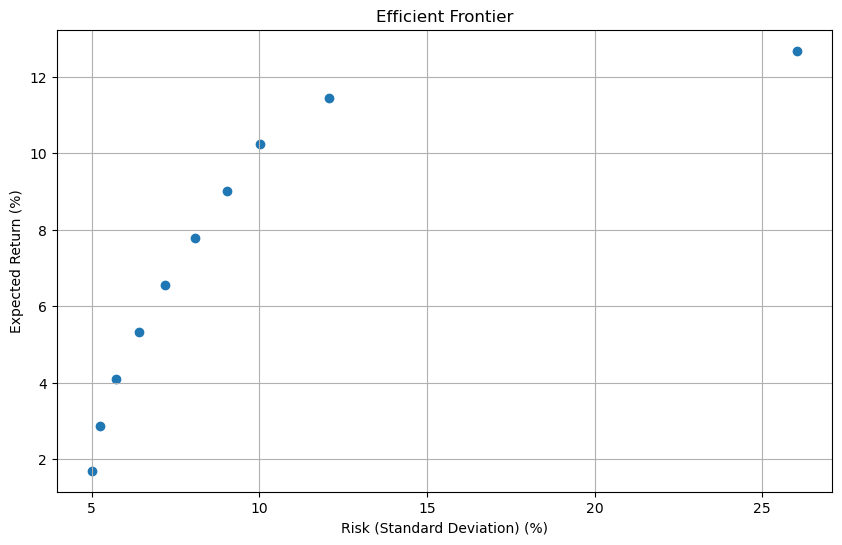

In [121]:
#Graph
plt.figure(figsize=(10, 6))
plt.scatter(
    efficient_frontier['Standard Deviation (%)'],
    efficient_frontier['Expected Return (%)'],
    marker='o'
)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation) (%)')
plt.ylabel('Expected Return (%)')
plt.grid(True)
plt.show()